<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2023/StatComponentSeparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf './scattering_transform/'
!git clone 'https://github.com/jecampagne/scattering_transform.git' './scattering_transform/'

Cloning into './scattering_transform'...
remote: Enumerating objects: 1434, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1434 (delta 273), reused 353 (delta 245), pack-reused 1050
Receiving objects: 100% (1434/1434), 194.56 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (915/915), done.


In [2]:
import sys
sys.path.append('/content/scattering_transform/')

In [3]:
import numpy as np

In [4]:
import torch
torch.__version__

'2.0.1+cu118'

In [5]:
if not torch.cuda.is_available():
  print("Hum.... try to get a GPU at least a T4 or K80 if you want to rerun the nb")

In [6]:
# import scattering package
import scattering

use torch backend


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
import os
os.chdir("/content/drive/My Drive/Data4CoursSMallat")

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# in case of problem
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [11]:
import time

# Introduction

This notebook intends to show how to use Scattering Transform to perform Microcanonical Modeling applyied to component separation. 

I will use the code originally setup by Sihao Cheng ([here is his github repo](https://github.com/SihaoCheng/scattering_transform))

One exemple of such component separation although using some other statistics/code is described in the article [J.-M. Delouis, E. Allys et al. ](https://arxiv.org/pdf/2207.12527.pdf)


We will use both the Scatetring coefficients used in the TextureSynthesis.ipynb notebook and also cross-correlation coefficients.

# Utils

In [19]:
def preprocess(x):
  if x.ndim != 3:
    x = x[np.newaxis]
  x = x.astype(np.float32)
  x = scattering.whiten(x)
  return x

In [16]:
def plot_2img(image1,image2, title_1='',title_2='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True, layout="constrained")
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    axs[0].set_xticks([]); axs[1].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());
 
def plot_3img(image1,image2, image3, title_1='',title_2='', title_3='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    img = axs[2].imshow(image3, vmin=vmin, vmax=vmax, cmap=cmap); axs[2].set_title(title_3);
    axs[0].set_xticks([]); axs[1].set_xticks([]); axs[2].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([]); axs[2].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());

In [14]:
torch.cuda.empty_cache()

# The use case

We use a raw signal image noted $s$ (*image_orig_raw*) of some field (Weak Leansing convergence map from a cosmological N-bodies simulation) (see TextureSyntheis notebook). We then add a white noise $n$ to the raw signal image and get a noisy signal *image_orig_noisy* $(d=s+n)$.  

The goal is to produce both a realisation of a distribution $\tilde{s}$ that has the same statistical properties as the raw signal $s$, and an estimate of the noise as $d-\tilde{s}$.

To do so, we will use several maps (Nr=10) of the presupposed known noise (ie. maps of white noise with the same sigma as the one used to get $d$). Then, we use a Gradient Descent minimisation of a loss composed of three items 

$$\begin{align}
\ell(u) = &\|\Phi_1(d)-\langle \Phi_1(u+n)\rangle_n \|^2  \\
 +&\| \Phi_2(d,u)-\langle \Phi_2(u+n,u)\rangle_n \|^2 \\
 +&\| \Phi_2(d,d)-\langle \Phi_2(u+n,u+n)\rangle_n \|^2 
\end{align}$$

$\Phi_1(x)$ stands for the some statistics used for texture synthesis, while $\Phi_2(x,y)$ stands for cross-correlation scattering coefficients (similar to $C_{i,j}$ ($i,j\in\{0,1\}$) but with two fields. Notice that $\langle f(u+n)\rangle_n$ is the mean of the function up on the $Nr$ noise maps.  

At initialisation $u(0) = d$, and at the end of the minimisation $u=\tilde{s}$ par définition. Of course, the loss should have reached at least a minimum stage. 


In [20]:
# load image
# you can adjust the size of the image if needed [::4,::4] leads to 128x128 pixels.
# The minimisation with scattering coeff will fit in a T4 GPU RAM (ie 8.6GB/15GB).
# Of course with bigger GPU RAM you try up to 512x512 (original size). 



image_orig_raw = preprocess(np.load("WLconv_z0.50_0001r.npy")[::4,::4])  

M,N =  image_orig_raw.shape[1],image_orig_raw.shape[2]

# generate a noise
sigma_n = 3.
image_wn_1 = np.random.default_rng(seed=1).normal(
                    0.,
                    sigma_n,
                    size=(M,N)
                )
image_wn_1 = image_wn_1[np.newaxis]

# define the noisy image
image_orig_noisy = image_orig_raw + image_wn_1

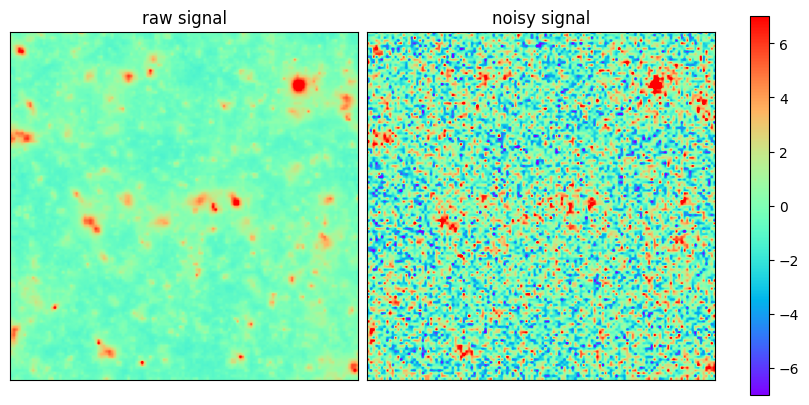

In [16]:
plot_2img(image_orig_raw[0],image_orig_noisy[0],title_1='raw signal',title_2="noisy signal", colorbar=True, figsize=(8,4), vminmax=(-7,7))

In [17]:
# initiliaze the Scattering Transform engine
J = int(np.log2(min(M,N))) - 1
L = 4

# Noise/Signal extraction

In [18]:
# Nr : number of noise simulation realisations (eg. Nr=10, the more is better but slower)
# Notice that with 128x128 images and Nr=10 on T4 GPU @ Colab this will take 1h or so.

Nr = 10
image_wn_n = np.random.default_rng(seed=2).normal(
                    0.,
                    sigma_n,
                    size=(Nr,M,N)
                )


In [19]:
# define loss function
def L2_loss(target, model,factor=1e8):
    return ((target - model)**2).mean()*factor

# to trigger if there is a problem
def test_no_nan(x):
    if type(x) == torch.Tensor or type(x) == torch.nn.parameter.Parameter:
        x = x.detach().cpu().numpy()
    return np.alltrue(~np.isnan(x))

In [20]:
def denoise_gen(
    target, image_init, images_noise,
    mode='image', optim_algorithm='LBFGS', steps=100, learning_rate=0.5,
    device='gpu', precision='single', print_each_step=False, Fourier=False,
    ensemble=False, 
    C11_criteria=None, J=None,L=4, wavelets='morlet',l_oversampling=1, frequency_factor=1,
    normalization='P00',
):
    # define parameters
    N_image = target.shape[0]
    M = target.shape[1]
    N = target.shape[2]
    
    #force cpu if no gpu available but it wil be very slow...
    if not torch.cuda.is_available(): device='cpu'
    
    if C11_criteria is None:
        C11_criteria = 'j2>=j1'

    if mode=='image':
        _, M, N = target.shape
        print('input_size: ', target.shape)
        
    if J is None:
        J = int(np.log2(min(M,N))) - 1
    
    #scattering transform 
    st_calc = scattering.ST.Scattering2d(M, N, J, L, device, wavelets, 
                           l_oversampling=l_oversampling, frequency_factor=frequency_factor)
    #index for 2-fields
    select_and_index = st_calc.get_index(J, L, normalization, C11_criteria, num_field = 2)

    
    if mode=='image':
        st_calc.add_ref(ref=target)   # stabilisation cov
        st_calc.add_ref_ab(ref_a=target, ref_b=target)  # stab cov_2fields
    
    # formating target and image_init (to tensor, to cuda)
    if type(target)==np.ndarray:
        target = torch.from_numpy(target)
    if type(image_init)==np.ndarray:
        image_init = torch.from_numpy(image_init)
    if type(images_noise)==np.ndarray:
        images_noise = torch.from_numpy(images_noise)
        
    if precision=='double':
        target = target.type(torch.DoubleTensor)
        image_init = image_init.type(torch.DoubleTensor)
        image_noise = image_noise.type(torch.DoubleTensor)
    else:
        target = target.type(torch.FloatTensor)
        image_init = image_init.type(torch.FloatTensor)
        images_noise = images_noise.type(torch.FloatTensor)
    if device=='gpu':
        target      = target.cuda()
        image_init  = image_init.cuda()
    
    # calculate statistics for target images alone
    
    if mode=='image':
        # Phi(d)
        Phi_t = st_calc.scattering_cov(target, use_ref=True,
            C11_criteria=C11_criteria, 
            normalization=normalization,)['for_synthesis']
        
        # S(d,d)
        coeff_target_target = st_calc.scattering_cov_2fields(target,target, use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
        C01_target_target = coeff_target_target['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
        C01_target_target_r = C01_target_target.real
        C01_target_target_i = C01_target_target.imag
        Corr11_target_target =  coeff_target_target['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
        Corr11_target_target_r = Corr11_target_target.real
        Corr11_target_target_i = Corr11_target_target.imag
        
        S_t_t = torch.cat((C01_target_target_r,C01_target_target_i,
                          Corr11_target_target_r,Corr11_target_target_i),
                         dim=-1)
        
    else:
        raise ValueError('mode = image only')

    # define optimizable image model
    class OptimizableImage(torch.nn.Module):
        def __init__(self, input_init, Fourier=False):
            # super(OptimizableImage, self).__init__()
            super().__init__()
            self.param = torch.nn.Parameter( input_init )
            
            if Fourier: 
                self.image = torch.fft.ifftn(
                    self.param[0] + 1j*self.param[1],
                    dim=(-2,-1)).real
            else: self.image = self.param
            
            
    if Fourier: 
        temp = torch.fft.fftn(image_init, dim=(-2,-1))
        input_init = torch.cat((temp.real[None,...], temp.imag[None,...]), dim=0)
    else: input_init = image_init
    image_model = OptimizableImage(input_init, Fourier)
    
    
    if optim_algorithm   =='Adam':
        optimizer = torch.optim.Adam(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='NAdam':
        optimizer = torch.optim.NAdam(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='SGD':
        optimizer = torch.optim.SGD(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='Adamax':
        optimizer = torch.optim.Adamax(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='LBFGS':
        optimizer = torch.optim.LBFGS(image_model.parameters(), lr=learning_rate, 
            max_iter=steps, max_eval=None, 
            tolerance_grad=1e-19, tolerance_change=1e-19, 
            history_size=min(steps//2, 150), line_search_fn=None)
    
    
    losses_hist = []
    N_noise_img = images_noise.shape[0]
    print("Nber of noise images: ",N_noise_img)

    
    def closure():
        optimizer.zero_grad()
        loss = 0
        
        model_img = image_model.image
        assert test_no_nan(model_img), 'model_img has NaN during optimization'        

        
        for i in range(N_noise_img):
            image_noise = images_noise[i]
            if device=='gpu':
                image_noise = image_noise.cuda()

            noisy_model_img = model_img+ image_noise
        
            #Phi(u+n)
            Phi_un = st_calc.scattering_cov(noisy_model_img, use_ref=True,
                C11_criteria=C11_criteria, 
                normalization=normalization,)['for_synthesis']

        
            #S(u+n, u+n)
            coeff_n_model_n_model = st_calc.scattering_cov_2fields(noisy_model_img,noisy_model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
            C01_n_model_n_model   = coeff_n_model_n_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
            C01_n_model_n_model_r = C01_n_model_n_model.real
            C01_n_model_n_model_i = C01_n_model_n_model.imag
            Corr11_n_model_n_model   =  coeff_n_model_n_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
            Corr11_n_model_n_model_r = Corr11_n_model_n_model.real
            Corr11_n_model_n_model_i = Corr11_n_model_n_model.imag
        
            S_un_un = torch.cat((C01_n_model_n_model_r, C01_n_model_n_model_i,
                             Corr11_n_model_n_model_r,Corr11_n_model_n_model_i),
                            dim=-1)
        
            # S(u+n,u)
            coeff_n_model_model =  st_calc.scattering_cov_2fields(noisy_model_img, model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
            Corr00_n_model_model   = coeff_n_model_model['Corr00'].reshape((N_image, -1))
            Corr00_n_model_model_r = Corr00_n_model_model.real
            Corr00_n_model_model_i = Corr00_n_model_model.imag
            C01_n_model_model   = coeff_n_model_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
            C01_n_model_model_r = C01_n_model_model.real
            C01_n_model_model_i = C01_n_model_model.imag
            Corr11_n_model_model   =  coeff_n_model_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
            Corr11_n_model_model_r = Corr11_n_model_model.real
            Corr11_n_model_model_i = Corr11_n_model_model.imag

            S_un_u = torch.cat((Corr00_n_model_model_r,Corr00_n_model_model_i,
                            C01_n_model_model_r,C01_n_model_model_i,
                            Corr11_n_model_model_r,Corr11_n_model_model_i),
                           dim=-1)
            
            if i==0:
                Phi_un_mean = Phi_un
                S_un_un_mean = S_un_un
                S_un_u_mean = S_un_u
            else:
                Phi_un_mean += Phi_un
                S_un_un_mean += S_un_un
                S_un_u_mean += S_un_u

            #free GPU memory
            del image_noise

        # finish the mean computations 
        Phi_un_mean /= N_noise_img
        S_un_un_mean /= N_noise_img
        S_un_u_mean /= N_noise_img

        # S(d,u)
        coeff_target_model =  st_calc.scattering_cov_2fields(target, model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
        Corr00_target_model   = coeff_target_model['Corr00'].reshape((N_image, -1))
        Corr00_target_model_r = Corr00_target_model.real
        Corr00_target_model_i = Corr00_target_model.imag
        C01_target_model   = coeff_target_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
        C01_target_model_r = C01_target_model.real
        C01_target_model_i = C01_target_model.imag
        Corr11_target_model   =  coeff_target_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
        Corr11_target_model_r = Corr11_target_model.real
        Corr11_target_model_i = Corr11_target_model.imag

        S_t_u = torch.cat((Corr00_target_model_r,Corr00_target_model_i,
                           C01_target_model_r,C01_target_model_i,
                           Corr11_target_model_r,Corr11_target_model_i),
                          dim=-1)
        
                            
        
        #Gather all peices and build the loss
        factor=1e8
        loss_Phi = L2_loss(Phi_t,Phi_un_mean, factor=factor/1e3)
        loss_S1  = L2_loss(S_t_u,S_un_u_mean, factor=factor)
        loss_S2  = L2_loss(S_t_t,S_un_un_mean,factor=factor)
        loss = loss_Phi + loss_S1 + loss_S2
        
        losses_hist.append([loss_Phi.item() ,loss_S1.item() , loss_S2.item()])
        
        
        if print_each_step:
            if optim_algorithm == 'LBFGS' or (optim_algorithm!='LBFGS' and (i%100==0 or i%100==-1)):
                print("loss_Phi= ",loss_Phi.item(),"loss_S1= ",loss_S1.item(),"loss_S2= ",loss_S2.item())
        loss.backward()
                
        return loss

    # optimize
    t_start = time.time()
    if optim_algorithm =='LBFGS':
        i=0
        optimizer.step(closure)
    else:
        for i in range(steps):
            #print('step: ', i)
            optimizer.step(closure)
    t_end = time.time()
    print('time used: ', t_end - t_start, 's')

    return image_model.image.cpu().detach().numpy(), np.array(losses_hist)

In [21]:
image_denoised,losses = denoise_gen(image_orig_noisy, image_orig_noisy, image_wn_n, 
                             print_each_step=False, steps=600, learning_rate=0.1, optim_algorithm="LBFGS")
#save 
np.save("losses.npy",losses)
np.save("raw_sig.npy", image_orig_raw[0])
np.save("noisy_sig.npy",image_orig_noisy[0])
np.save("denoised.npy",image_denoised[0])

input_size:  (1, 128, 128)
Nber of noise images:  10
time used:  3558.5235509872437 s


In [21]:
losses = np.load("losses.npy")
image_orig_raw = np.load("raw_sig.npy")
image_orig_noisy = np.load("noisy_sig.npy")
image_denoised = np.load("denoised.npy")

# Results



## Let us look first at the loss history (the different components as well as the total).

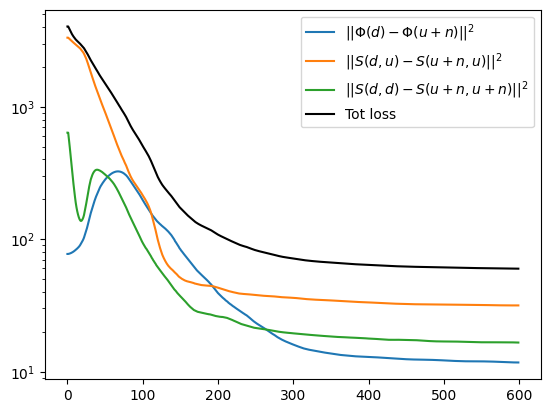

In [22]:
plot(losses[:,0],label="$||\Phi(d)-\Phi(u+n)||^2$")
plot(losses[:,1],label="$||S(d,u)-S(u+n,u)||^2$")
plot(losses[:,2],label="$||S(d,d)-S(u+n,u+n)||^2$")
plot(losses[:,0]+losses[:,1]+losses[:,2],label="Tot loss",c="k")
yscale("log")
legend()

## Then have a look at the denoising process outputs.

Below $s$, and $d$ are noted **raw**, **noisy**, while $\tilde{s}$ is noted **denoised**. One can see that the denoised image is not perfect but is less noisy then the original noisy one. I provide also the result using 256x256 images instead as 128x128 which is the only size that a T4 can keep up on Google Collab. One can judge that increasing the image size helps.

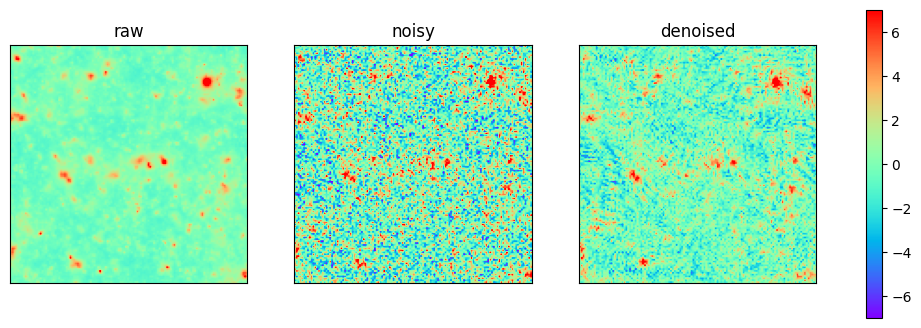

In [23]:
plot_3img(image_orig_raw,image_orig_noisy, image_denoised, colorbar=True, figsize=(13, 4),
         title_1="raw",title_2="noisy",title_3="denoised", vminmax=(-7,7))

We can also have a look at the noise map  estiamted ($d-\tilde{s}$) compared to the noise map used to get $d=s+n$. There is no systematic biais at least at first look. So, the component separation $d\rightarrow (\tilde{s}, \tilde{n}=d-\tilde{s}$) is satisfactory for this simple exercice. The paper mentionned in the introduction is a more advenced real case scenario.

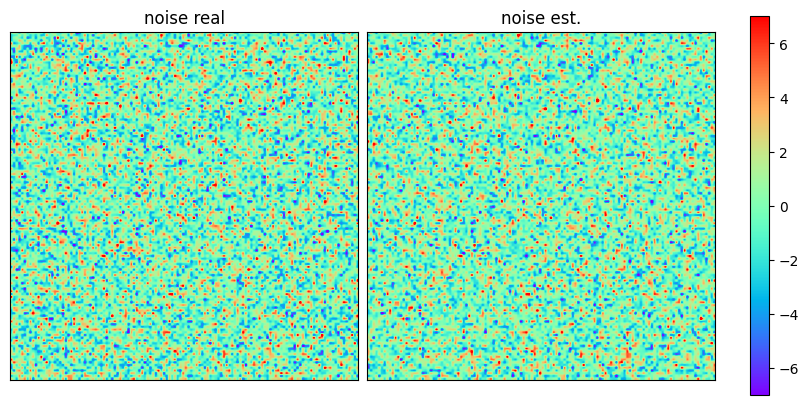

In [28]:
plot_2img(image_wn_1[0],image_orig_noisy-image_denoised,colorbar=True, figsize=(8, 4),
         title_1="noise real",title_2="noise est.", vminmax=(-7,7))

In [38]:
# In case you have not the opportunity to run with 256x256 here the result. More pixel you have better is the result.
import PIL
from PIL import Image
class ImageUtils(object):
    @classmethod
    def resize_image(cls, image: PIL.Image.Image, width=None, height=None) -> PIL.Image.Image:
        if height is None and width is not None:
            height = image.height * width // image.width
        elif width is None and height is not None:
            width = image.width * height // image.height
        elif height is None and width is None:
            raise RuntimeError("At lease one of width and height must be present")
        return image.resize((width, height))



In [ ]:

result_256x256_1 = Image.open("./denoised_256x256_1.png")
result_256x256_2 = Image.open("./denoised_256x256_2.png")

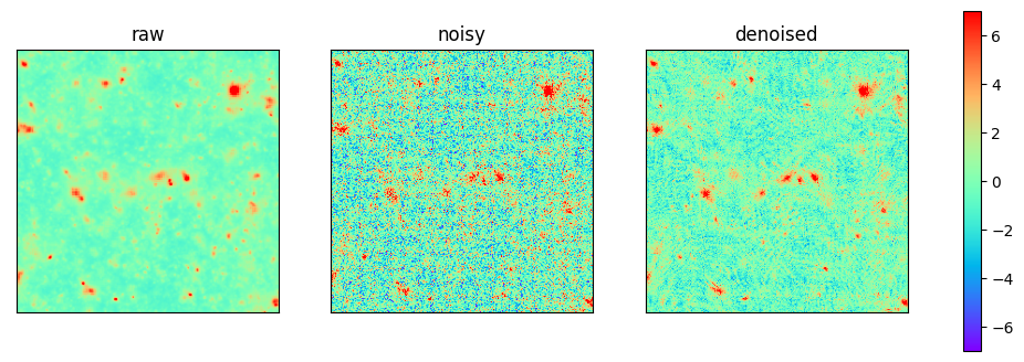

In [42]:
ImageUtils.resize_image(result_256x256_1, width = 1024)

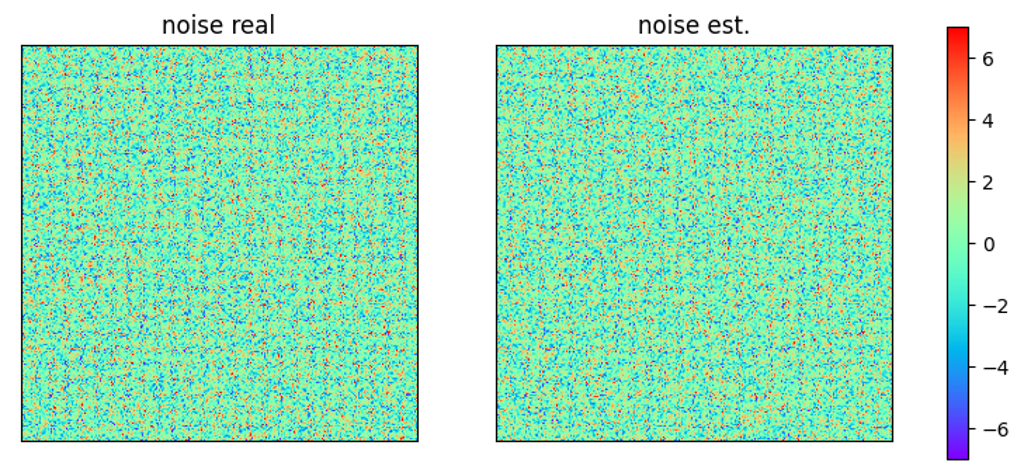

In [43]:
ImageUtils.resize_image(result_256x256_2, width = 1024)